# **Deep Learning LAB 3**

Improving on last weeks lab 2, we will extend our model to use convolutional and pooling layers to improve the accuracy of the model

This lab is slightly adapted from an online tutorial by Adrian Rosebrock.

Read the code in each of the steps carefully with the aim of fully understand what is going on (the instructor will help as needed),. Then run each step.

Once, you have finished going through all the steps, try to improve the test accuracy of the CNN, for example, by:

*   using different activation function in the hidden layers
*   increase number of layers
*   changing pooling parameters
*   augmenting the data

Were you able to improve the test accuracy of the network? By how much? Which enhancements worked the best? Show your result to the lab instructor.






# Step 1:  "Upload" the images in Colaboratory


In [0]:
import os

# Three thousand images of cats, dogs, and pandas (1000 each)
if not os.path.exists('./lab2'):
  !wget https://www.ru.is/~yngvi/ML/lab2.tgz
  !tar -xzf lab2.tgz

# Step 2: Import necessary Python packages

Apart from the necessary Keras packages, we will be using several other support libraries to make our life easier, for example, OpenCV for reading in (and manipulating) images, SciKit for transformations, etc.


In [0]:
import random

import cv2
import numpy as np

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

from keras import regularizers
from keras.models import Sequential
from keras.layers.core import Dense, SpatialDropout1D
from keras.optimizers import SGD, rmsprop, Adam, Nadam
from sklearn.metrics import classification_report
from keras.layers import Conv2D, Flatten, MaxPooling2D, Activation, Dropout
from keras.layers.normalization import BatchNormalization


import matplotlib.pyplot as plt

random_seed = 42   # include for reproducability

Using TensorFlow backend.


# Step 3: Read in the filesystem paths of the images

In [0]:
print("[INFO] loading images...")

# Specify locations of input and output files.
tutorial_dir = "./lab2/"
args = {}
args["dataset"] = tutorial_dir + "animals/"
args["model"]   = tutorial_dir + "output/simple_nn.model"
args["plot"]    = tutorial_dir + "output/simple_nn_plot.png"

# Read in the file paths of the images to use for the training.
image_paths = list()
for (dirpath, dirnames, filenames) in os.walk(args["dataset"]):
    for file in filenames:
        if '.jpg' in file and not file.startswith('.'):
              image_paths.append(os.path.join(dirpath, file))
                
random.seed(random_seed)
random.shuffle(image_paths)

[INFO] loading images...


# Define the preprocesses dimensions of the images

In [0]:
sz = 64

# Step 4: Read in and preprocess the images
Define a function preprocess_img which given an image and a variable called size, returns a preprocessed image, which is more suitable for a convolutional neural network

The actions that we want to do are as follows:


1.   Resize the image to be of dimensions size x size



In [0]:
def preprocess_img(img, size):
  img2 = cv2.resize(img, dsize=(size, size), interpolation=cv2.INTER_NEAREST)
  img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
  return img2

def show_images(imgs, grid_size=3):
  f, axarr = plt.subplots(grid_size,grid_size, figsize=(15, 15))
  for i in range(grid_size):
    for j in range(grid_size):
      axarr[i,j].imshow(imgs[i*grid_size+j])
  plt.show()


# Step 5: Split the data into test and training set, and reformat target values

In [0]:
input_data   = []
input_labels = []
original_imgs = []
for image_path in image_paths:
    image = cv2.imread(image_path)
    original_imgs.append(image)
    image = preprocess_img(image, sz)
    input_data.append(image)
    label = image_path.split(os.path.sep)[-2]
    input_labels.append(label)
    
input_data   = np.array(input_data)# maybe this should be changed
input_labels = np.array(input_labels)

# Split the data into training and testing sets
(trainX, testX, trainY, testY) = train_test_split(input_data, 
                                                  input_labels, 
                                                  test_size=0.2, 
                                                  random_state=random_seed)
# Convert the target categorial labels into binary vectors 
# (for 2-class, binary classification you should use Keras' 
#  to_categorical function instead as the scikit-learn's LabelBinarizer)
lb = LabelBinarizer()    # ... from scikit
trainY = lb.fit_transform(trainY)  # ... from scikit
testY  = lb.transform(testY)       # ... from scikit

# Original images


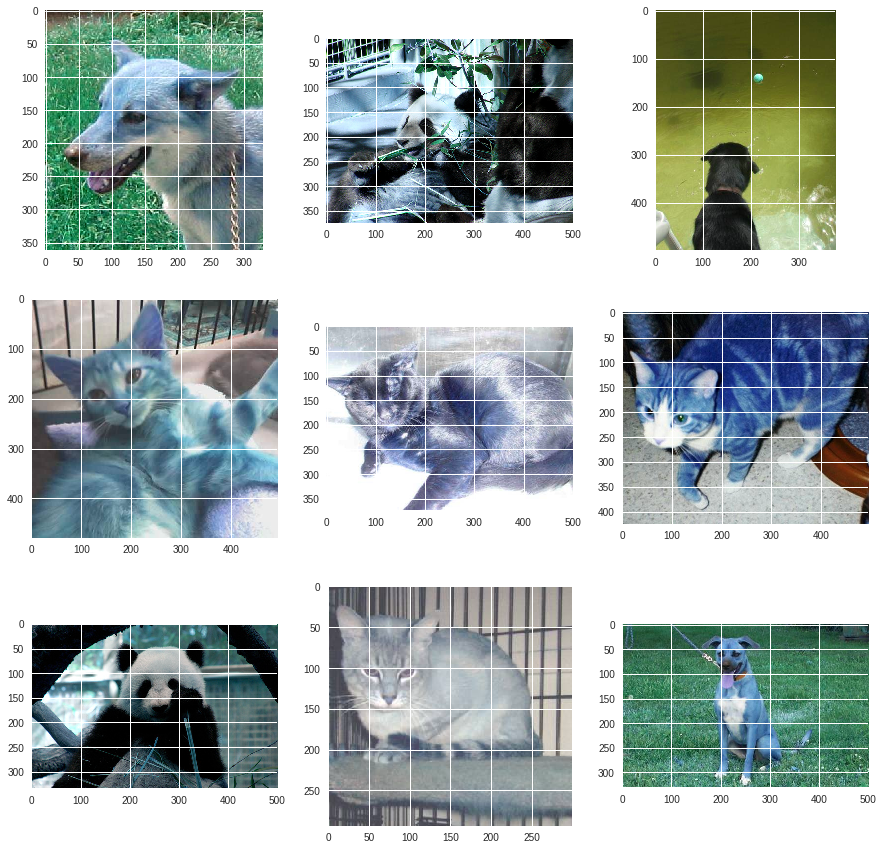

In [0]:
show_images(original_imgs)

# Preprocessed images

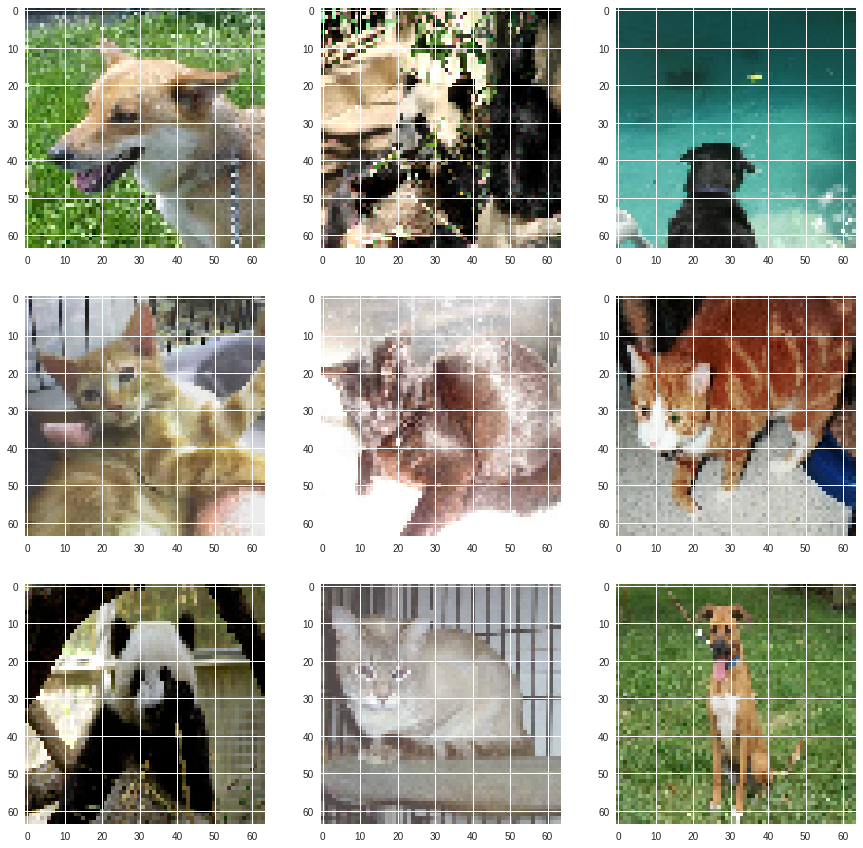

In [0]:
show_images(input_data)

# Step 5: Create the ANN model, train it, and then evaluate it

In [0]:
model = Sequential()

trainX = trainX.reshape(trainX.shape[0],sz,sz,3) # if you've converted everything to grayscale
testX = testX.reshape(testX.shape[0],sz,sz,3)    # then change the last argument to 1 instead of 3

chanDim = -1 # change this to 1 if you're using theano as a backend

# Layer 1
model.add(Conv2D(32, (3, 3), padding="same",input_shape=trainX.shape[1:]))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))

# Layer 2
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Layer 3
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))

# Layer 4
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))

# Layer 5
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Layer 6
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))

# Layer 7
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))

# Layer 8
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))

# Layer 9
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Layer 10
model.add(Flatten()) # it is important to flatten your 2d tensors to 1d when going to FC-layers
model.add(Dense(512, bias_initializer='ones'))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Output Layer
model.add(Dense(len(lb.classes_)))
model.add(Activation("softmax"))

EPOCHS = 5

trainX = trainX.astype('float64')
testX = testX.astype('float64')

#trainX /= 255.0
#testX /= 255.0

print("[INFO] training network...")
opt = rmsprop(lr=0.0001, decay=1e-6)

model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

# Now train the ANN ...
H = model.fit(trainX, trainY, validation_data=(testX, testY), epochs=EPOCHS, batch_size=32)

# ... and then evaluate it.
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1),
	       predictions.argmax(axis=1), target_names=lb.classes_))

# Store the model on disk.
print("[INFO] serializing and storing the model ...")
model.save(args["model"])


[INFO] training network...
Train on 2400 samples, validate on 600 samples
Epoch 1/100
2400/2400 [==============================] - 8s 3ms/step - loss: 1.2689 - acc: 0.5713 - val_loss: 0.9553 - val_acc: 0.6217
Epoch 2/100
2400/2400 [==============================] - 5s 2ms/step - loss: 1.0603 - acc: 0.6258 - val_loss: 0.9817 - val_acc: 0.6233
Epoch 3/100
2400/2400 [==============================] - 5s 2ms/step - loss: 0.9057 - acc: 0.6658 - val_loss: 0.9660 - val_acc: 0.6350
Epoch 4/100
2400/2400 [==============================] - 5s 2ms/step - loss: 0.8668 - acc: 0.6758 - val_loss: 0.9585 - val_acc: 0.6417
Epoch 5/100
2400/2400 [==============================] - 5s 2ms/step - loss: 0.7982 - acc: 0.6796 - val_loss: 0.8456 - val_acc: 0.6650
Epoch 6/100
2400/2400 [==============================] - 4s 2ms/step - loss: 0.7266 - acc: 0.7067 - val_loss: 0.8073 - val_acc: 0.6783
Epoch 7/100
2400/2400 [==============================] - 4s 2ms/step - loss: 0.6740 - acc: 0.7292 - val_loss: 1.0287

# Visualization of the CNN

It is important to note that the sizes of each layer have been reduced to make the image more understandable, the image is more to emphasize the actions done in each layer.

![alt text](https://raw.githubusercontent.com/Sigurdurhelga/Sigurdurhelga.github.io/master/Downloads/cnn.jpg)

# Output a graph with information about learning progress.


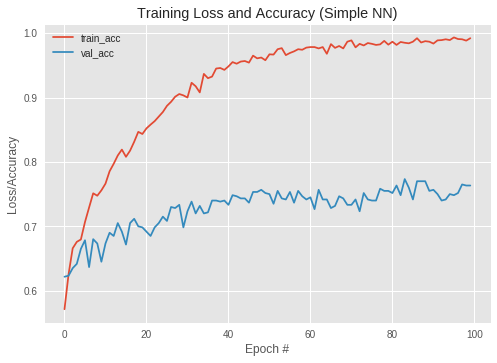

In [0]:
# Plot the training loss and accuracy
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
#plt.plot(N, H.history["loss"], label="train_loss")
#plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["acc"], label="train_acc")
plt.plot(N, H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy (Simple NN)")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig(args["plot"])

# Possible Improvements

Now you should try to play around with the data to get the highest possble evaluation score you can get. There are many possible steps for you to take, we recommend these

*   Bolster your dataset through data augmentation, to do so just add additional steps in the preprocess_img function
*   Play with the Neural Network with additional layers, other optimizers, adding regularizers, or any other thing you might think of
*   Do bagging/boosting or implement other models and setup an ensemble method


With minimal adjustments you should reach accuracy in the 75% region.